In [1]:
import os
import time
import yaml
import importlib
import sys

import talib as ta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras import backend as K
import tensorflow as tf
from tensorflow.keras import layers

sys.path.insert(0, os.path.join(os.path.abspath(os.getcwd()), '..', '..'))

from src.models.transformer import Time2Vec, TransformerEncoder, TransformerDecoder
from src.plotting import plot_observable_list_same_axis
from src.preprocessing.preprocessing_big import preprocess, window_series, make_dataset

In [4]:
input_dir = os.path.join(os.path.abspath(os.getcwd()), '..', '..', 'input')

output_dir = 'output'
pred_plots_dir = os.path.join(output_dir, 'pred_plots')
models_dir = os.path.join(output_dir, 'models')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

if not os.path.exists(pred_plots_dir):
    os.makedirs(pred_plots_dir)
    
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

In [5]:
step = 1
enc_steps_in = 1
dec_steps_in = 1
dec_steps_out = 1

val_date = '2021-05-08'
test_date = '2022-05-08'

excluded_features = [
    'date', 
    'open',
]

btc_config_file = {
    'step': step,
    'val_date': val_date,  
    'test_date': test_date, 
    'enc_steps_in': enc_steps_in,
    'dec_steps_in': dec_steps_in,
    'dec_steps_out': dec_steps_out,
    'excluded_features': excluded_features,
}

train_config_file = {
    'val_date': None,
    'test_date': None,
    'step': step,
    'enc_steps_in': enc_steps_in,
    'dec_steps_in': dec_steps_in,
    'dec_steps_out': dec_steps_out,
    'excluded_features': excluded_features,
}

filename_list = ['LTC-USD.csv', 'ETH-USD.csv', 'ADA-USD.csv', 'XRP-USD.csv', 'XMR-USD.csv', 'DOT-USD.csv', 'SOL-USD.csv']

In [7]:
for filename in filename_list[:1]:
    filepath = os.path.join(input_dir, filename)
    X_train_enc, X_train_dec, y_train, _, _, _, _, _, _, _, _ = make_dataset(filepath, **train_config_file)

for filename in filename_list[1:]:
    filepath = os.path.join(input_dir, filename)
    pair_X_train_enc, pair_X_train_dec, pair_y_train, _, _, _, _, _, _, _, _ = make_dataset(filepath, **train_config_file)
    
    X_train_enc = np.concatenate([X_train_enc, pair_X_train_enc])
    X_train_dec = np.concatenate([X_train_dec, pair_X_train_dec])
    y_train = np.concatenate([y_train, pair_y_train])

btc_X_train_enc, btc_X_train_dec, btc_y_train, X_val_enc, X_val_dec, y_val, X_test_enc, X_test_dec, y_test, scaler, features_list = make_dataset(os.path.join(input_dir, 'BTC-USD.csv'), **btc_config_file)

X_train_enc = np.concatenate([X_train_enc, btc_X_train_enc])
X_train_dec = np.concatenate([X_train_dec, btc_X_train_dec])
y_train = np.concatenate([y_train, btc_y_train])

In [8]:
X_train_enc.shape, X_train_dec.shape, y_train.shape

((11624, 1, 147), (11624, 1, 147), (11624, 1, 147))

In [9]:
X_val_enc.shape, X_val_dec.shape, y_val.shape

((363, 1, 147), (363, 1, 147), (363, 1, 147))

In [10]:
X_test_enc.shape, X_test_dec.shape, y_test.shape

((30, 1, 147), (30, 1, 147), (30, 1, 147))

In [11]:
n_features = len(features_list)
dense_dim = 10
num_heads = 5
dropout = 0.1
random_seed = 123

opt_func='adam' 
loss_func='mse'

tf.keras.backend.clear_session()
tf.random.set_seed(random_seed)


encoder_inputs = keras.Input(shape=(enc_steps_in, n_features))
encoder_time_embedding = keras.layers.TimeDistributed(Time2Vec(kernel_size=1))(encoder_inputs)
x = K.concatenate([encoder_inputs, encoder_time_embedding], -1)
x = TransformerEncoder(x.shape[2], dense_dim, num_heads)(x)
encoder_outputs = layers.Dense(n_features)(x)


decoder_inputs = keras.Input(shape=(dec_steps_in, n_features))
decoder_time_embedding = keras.layers.TimeDistributed(Time2Vec(kernel_size=1))(decoder_inputs)
x = K.concatenate([encoder_inputs, encoder_time_embedding], -1)
x = TransformerDecoder(x.shape[2], dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(dropout)(x)
decoder_outputs = layers.Dense(n_features)(x)


model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [12]:
timestamp = time.strftime('run_%Y_%m_%d-%H_%M_%S')
run_logdir = os.path.join(output_dir, 'runs', timestamp)

if not os.path.exists(run_logdir):
    os.makedirs(run_logdir)

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='loss', patience=50),
    keras.callbacks.ModelCheckpoint(filepath=os.path.join(models_dir, f'model_{timestamp}.keras'), monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.TensorBoard(run_logdir)
]

model.compile(optimizer=opt_func, loss=loss_func)
model.fit([X_train_enc, X_train_dec], 
          y_train,
          validation_data=([X_val_enc, X_val_dec], y_val),
          epochs=300,
          shuffle=True,
          verbose=0,
          callbacks=callbacks_list)

2022-06-10 20:02:16.775787: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-10 20:02:17.825591: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204


In [13]:
model = keras.models.load_model(
    os.path.join(models_dir, f'model_{timestamp}.keras'),
    custom_objects={
        "Time2Vec": Time2Vec, 
        "TransformerEncoder": TransformerEncoder,
        "TransformerDecoder": TransformerDecoder})

In [14]:
val_mse = model.evaluate([X_val_enc, X_val_dec], y_val)
print(f"Val mse: {val_mse}")

12/12 [==============================] - 0s 2ms/step - loss: 5.8097e-04
Val mse: 0.000580972118768841


In [15]:
test_mse = model.evaluate([X_test_enc, X_test_dec], y_test)
print(f"Test mse: {test_mse}")

1/1 [==============================] - 0s 13ms/step - loss: 1.7994e-04
Test mse: 0.00017994009249377996


In [16]:
dict_file = {'enc_steps_in': enc_steps_in, 
             'dec_steps_in': dec_steps_in, 
             'dec_steps_out': dec_steps_out, 
             'dense_dim': dense_dim, 
             'num_heads': num_heads, 
             'dropout': dropout,
             'opt_func': opt_func,
             'loss_func': loss_func,
             'val_date': val_date,  
             'test_date': test_date, 
             'val_mse': val_mse,
             'test_mse': test_mse,
             'features_list': features_list}

with open(os.path.join(output_dir, 'models', f'{timestamp}.yml'), 'w') as file:
    documents = yaml.dump(dict_file, file)

## PLOT PREDICTIONS

### VALIDATION DATASET

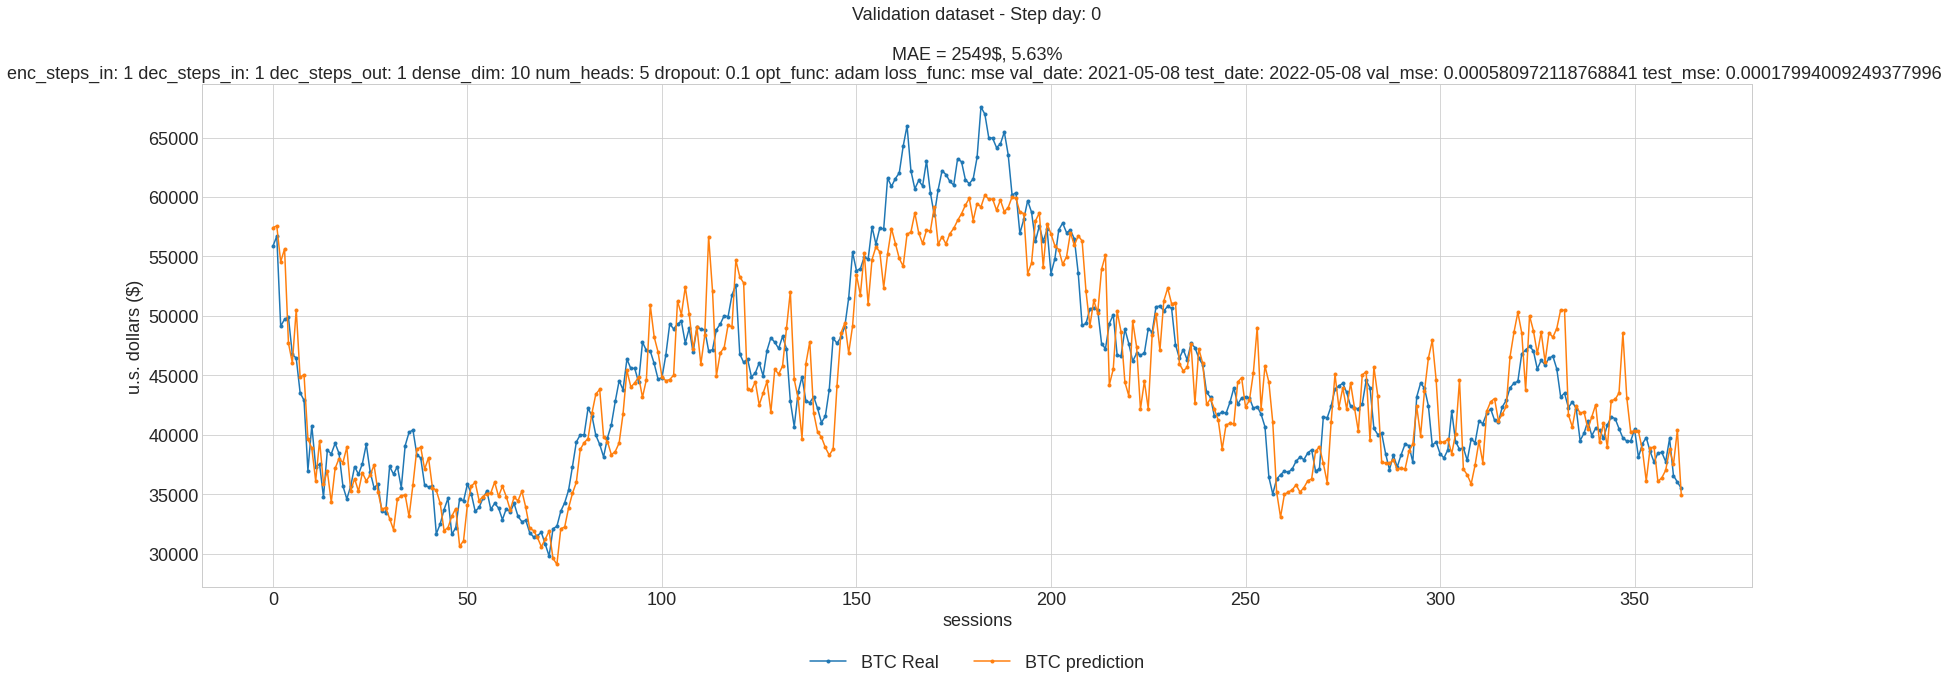

In [17]:
# Make predictions
y_pred = model([X_val_enc, X_val_dec])

# Convert to real values
y_pred_unscaled = [scaler.inverse_transform(y) for y in y_pred]
y_val_unscaled = [scaler.inverse_transform(y) for y in y_val]

# First column is price
unscaled_pred_price = np.array([pred[:, 0] for pred in y_pred_unscaled])
unscaled_val_price = np.array([obs[:, 0] for obs in y_val_unscaled])

subtitle = ''
for k, v in dict_file.items():
    if k != 'features_list':
        subtitle += f'{k}: {v} '
    # else:
        # subtitle += f'\nFeatures list:\n{v}'

for day in range(dec_steps_out):
    figname = os.path.join(pred_plots_dir, f'{timestamp}_validation_predictions_d{day}.png')
    y_list = [unscaled_val_price[:,day], unscaled_pred_price[:,day]]
    x_ticks = range(len(y_list[0]))
    
    mae = tf.keras.losses.MeanAbsoluteError()
    mae_value = int(mae(unscaled_val_price[:,day], unscaled_pred_price[:,day]).numpy())
    mae_perc = round(((abs(unscaled_val_price[:,day] - unscaled_pred_price[:,day]) / unscaled_val_price[:,day]) * 100).mean(), 2)
    
    plot_observable_list_same_axis(x=x_ticks, 
                                   y_list=y_list,
                                   xlabel='sessions',
                                   ylabel='u.s. dollars ($)',
                                   title=f'Validation dataset - Step day: {day}\n\nMAE = {mae_value}$, {mae_perc}%\n{subtitle}',
                                   legend=['BTC Real', 'BTC prediction'],
                                   fontsize=18,
                                   markersize=3,
                                   bbox_to_anchor=(0.5, -0.20),
                                   figname=figname)

### TEST DATASET

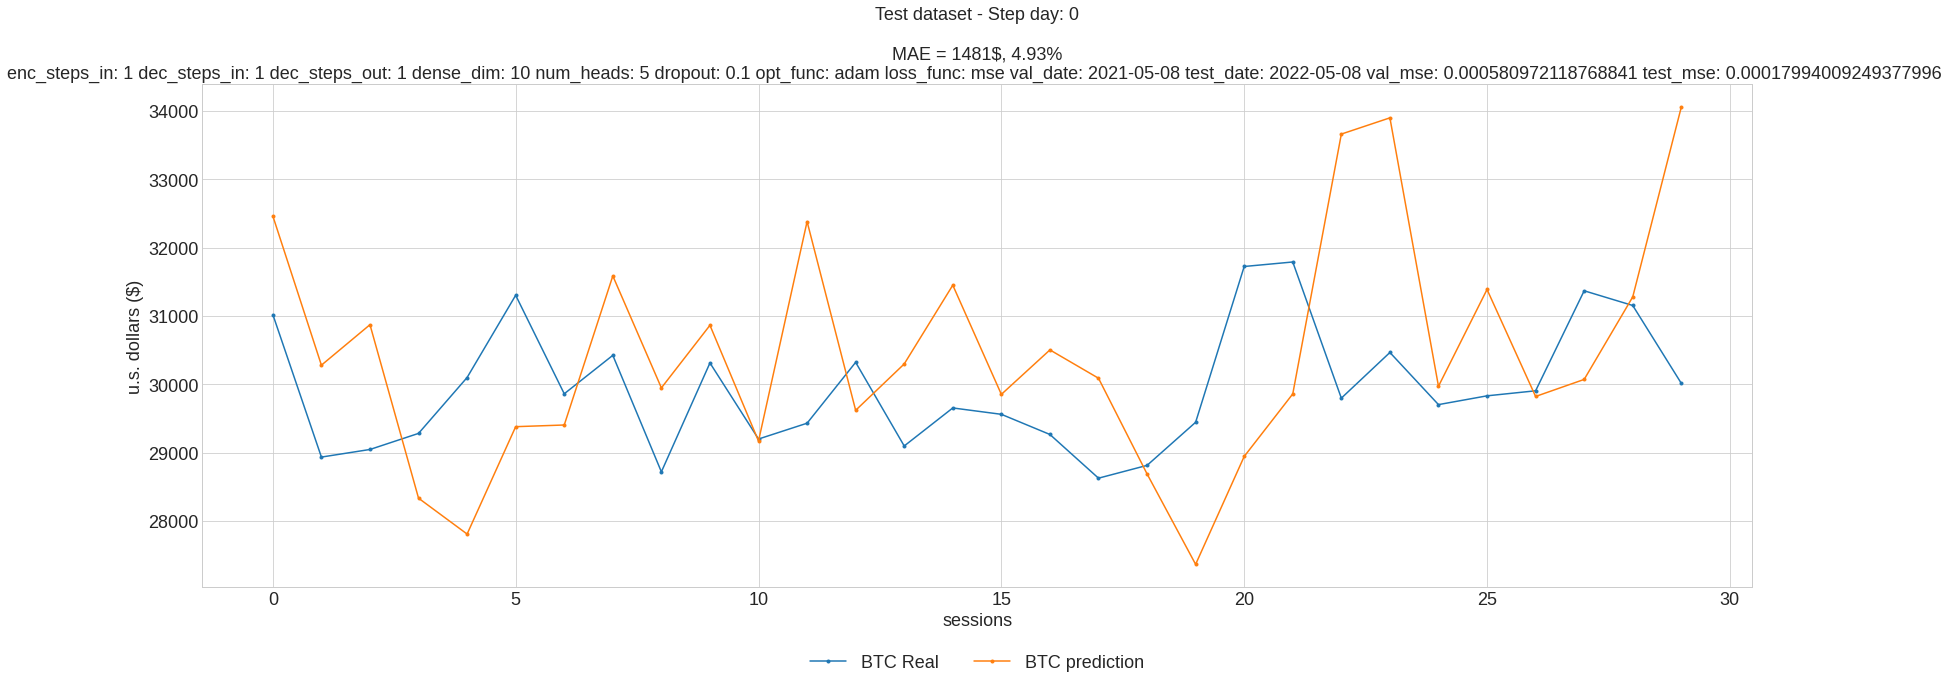

In [18]:
# Make predictions
y_pred = model([X_test_enc, X_test_dec])

# Convert to real values
y_pred_unscaled = [scaler.inverse_transform(y) for y in y_pred]
y_test_unscaled = [scaler.inverse_transform(y) for y in y_test]

# First column is price
unscaled_pred_price = np.array([pred[:, 0] for pred in y_pred_unscaled])
unscaled_test_price = np.array([obs[:, 0] for obs in y_test_unscaled])

subtitle = ''
for k, v in dict_file.items():
    if k != 'features_list':
        subtitle += f'{k}: {v} '
    # else:
        # subtitle += f'\nFeatures list:\n{v}'

for day in range(dec_steps_out):
    figname = os.path.join(pred_plots_dir, f'{timestamp}_test_predictions_d{day}.png')
    y_list = [unscaled_test_price[:,day], unscaled_pred_price[:,day]]
    x_ticks = range(len(y_list[0]))
    
    mae = tf.keras.losses.MeanAbsoluteError()
    mae_value = int(mae(unscaled_test_price[:,day], unscaled_pred_price[:,day]).numpy())
    mae_perc = round(((abs(unscaled_test_price[:,day] - unscaled_pred_price[:,day]) / unscaled_test_price[:,day]) * 100).mean(), 2)
    
    plot_observable_list_same_axis(x=x_ticks, 
                                   y_list=y_list,
                                   xlabel='sessions',
                                   ylabel='u.s. dollars ($)',
                                   title=f'Test dataset - Step day: {day}\n\nMAE = {mae_value}$, {mae_perc}%\n{subtitle}',
                                   legend=['BTC Real', 'BTC prediction'],
                                   fontsize=18,
                                   markersize=3,
                                   bbox_to_anchor=(0.5, -0.20),
                                   figname=figname)